In [3]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pennylane as qml
import matplotlib.pyplot as plt


In [4]:
def extract_target_property(metadata):
    """
    Tries to extract a numerical target property from the last few lines of metadata.
    Assumes the target is the last valid float number.
    """
    target_property = np.nan  # Default to NaN in case no value is found
    
    # Traverse the metadata to find the last valid numerical value
    for line in reversed(metadata):
        for value in reversed(line.strip().split()):
            try:
                target_property = float(value)
                return target_property  # Return the first valid float found
            except ValueError:
                continue  # Skip non-numeric values
                
    return target_property  # Return NaN if no numeric value is found

In [5]:
# Directory containing the XYZ files
xyz_dir = "QM9/dsgdb9nsd.xyz"

def parse_xyz(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
        # Step 1: Get the number of atoms
        num_atoms = int(lines[0].strip())
        
        # Step 2: Extract atomic types and coordinates
        atom_types = []
        coordinates = []
        
        for i in range(2, 2 + num_atoms):
            parts = lines[i].strip().split()
            atom_types.append(parts[0])  # Atom symbol (C, H, O, etc.)
            coords = [float(part.replace('*^', 'e')) for part in parts[1:4]]
            coordinates.append(coords)
        
        # Step 3: Extract the metadata and target property
        metadata_start = 2 + num_atoms
        metadata = lines[metadata_start:]
        target_property = extract_target_property(metadata)
        
        return atom_types, np.array(coordinates), target_property


In [6]:
from scipy.spatial.distance import pdist, squareform
from collections import Counter

def compute_features(atom_types, coordinates):
    # Step 1: Count the number of atoms of each type (C, H, O)
    atom_counts = Counter(atom_types)
    num_c = atom_counts.get('C', 0)
    num_h = atom_counts.get('H', 0)
    num_o = atom_counts.get('O', 0)
    
    # Step 2: Compute pairwise distances between all atoms
    pairwise_distances = squareform(pdist(coordinates))
    
    # Step 3: Compute the mean and max pairwise distances
    mean_distance = np.mean(pairwise_distances)
    max_distance = np.max(pairwise_distances)
    
    # Step 4: Return the feature vector (you can extend this as needed)
    return np.array([num_c, num_h, num_o, mean_distance, max_distance])


In [7]:
def generate_synthetic_target(features):
    # Use a linear combination of features as a temporary target
    return 0.5 * features[3] + 0.3 * features[4]  # Mean distance + max distance (adjust as needed)


In [8]:
# Store parsed data
molecule_data = []

for file_name in os.listdir(xyz_dir):
    if file_name.endswith(".xyz"):
        file_path = os.path.join(xyz_dir, file_name)
        atom_types, coordinates, target_property = parse_xyz(file_path)
        features = compute_features(atom_types, coordinates)
        
        # If target property is NaN, generate a synthetic target
        if np.isnan(target_property):
            target_property = generate_synthetic_target(features)
        
        molecule_data.append({
            "file_name": file_name,
            "features": features,
            "target_property": target_property
        })

# Convert to DataFrame
df = pd.DataFrame(molecule_data)
print(df.head())


              file_name                                           features  \
0  dsgdb9nsd_000001.xyz  [1.0, 4.0, 0.0, 1.2053341170795622, 1.78315766...   
1  dsgdb9nsd_000002.xyz  [0.0, 3.0, 0.0, 0.9884404226522757, 1.61870992...   
2  dsgdb9nsd_000003.xyz  [0.0, 2.0, 1.0, 0.7639047756163965, 1.51335786...   
3  dsgdb9nsd_000004.xyz      [2.0, 2.0, 0.0, 1.396113812525, 3.3232771722]   
4  dsgdb9nsd_000005.xyz  [1.0, 1.0, 0.0, 0.9859315432225048, 2.21834597...   

   target_property  
0        3151.7078  
1        3575.3343  
2        3907.6980  
3        3557.8599  
4        3490.3686  


In [9]:
# Check the number of NaNs in the target property
nan_count = df['target_property'].isna().sum()
total_count = len(df)

print(f"Number of NaN values in target property: {nan_count}")
print(f"Percentage of NaNs: {(nan_count / total_count) * 100:.2f}%")


Number of NaN values in target property: 0
Percentage of NaNs: 0.00%


In [10]:
# Print the last 10 lines of the first XYZ file
file_path = os.path.join(xyz_dir, "dsgdb9nsd_000001.xyz")
with open(file_path, 'r') as f:
    lines = f.readlines()
    print("".join(lines[-10:]))  # Print the last 10 lines for inspection


5
gdb 1	157.7118	157.70997	157.70699	0.	13.21	-0.3877	0.1171	0.5048	35.3641	0.044749	-40.47893	-40.476062	-40.475117	-40.498597	6.469	
C	-0.0126981359	 1.0858041578	 0.0080009958	-0.535689
H	 0.002150416	-0.0060313176	 0.0019761204	 0.133921
H	 1.0117308433	 1.4637511618	 0.0002765748	 0.133922
H	-0.540815069	 1.4475266138	-0.8766437152	 0.133923
H	-0.5238136345	 1.4379326443	 0.9063972942	 0.133923
1341.307	1341.3284	1341.365	1562.6731	1562.7453	3038.3205	3151.6034	3151.6788	3151.7078
C	C	
InChI=1S/CH4/h1H4	InChI=1S/CH4/h1H4



In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Expand the features column into a NumPy feature matrix
X = np.array([np.array(f) for f in df['features']])

# Target vector (target_property)
y = df['target_property'].values

# Split the dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features and target using StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (107108, 5)
Test set shape: (26777, 5)


In [40]:
import pennylane as qml

# Number of qubits = number of features (for simplicity)
n_qubits = X_train.shape[1]
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define the parameterized quantum circuit
@qml.qnode(dev)
def qnn_circuit(inputs, weights):
    # Step 1: Encode input features using rotation gates
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    # Step 2: Apply parameterized rotations
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
        qml.RZ(weights[n_qubits + i], wires=i)
    
    # Step 3: Apply entangling CNOT gates
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    
    # Step 4: Measure the expectation value
    return qml.expval(qml.PauliZ(0))


In [ ]:
from pennylane import numpy as np
from sklearn.metrics import mean_squared_error

# Initialize random weights
weights = np.random.randn(2 * n_qubits)

# Define the cost function
def huber_loss(weights, X, y, delta=1.0):
    predictions = np.array([qnn_circuit(x, weights) for x in X])
    residuals = np.abs(predictions - y)
    
    # Apply Huber loss
    loss = np.where(residuals <= delta,
                    0.5 * residuals**2,
                    delta * residuals - 0.5 * delta**2)
    
    return np.mean(loss)

# Use an optimizer (e.g., Gradient Descent)
opt = qml.GradientDescentOptimizer(stepsize=0.1)
n_iterations = 30

# Training loop
for iteration in range(n_iterations):
    weights = opt.step(lambda w: huber_loss(w, X_train, y_train), weights)
    if iteration % 10 == 0:
        train_loss = huber_loss(weights, X_train, y_train)
        print(f"Iteration {iteration}: Training Loss = {train_loss:.4f}")


Iteration 0: Training Loss = 1.7600
Iteration 10: Training Loss = 1.6915
Iteration 20: Training Loss = 1.5475


In [42]:
from sklearn.metrics import r2_score

# Make predictions on the test set
predictions = np.array([qnn_circuit(x, weights) for x in X_test])

# Inverse-transform the predictions and targets back to the original scale
predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_test_original, predictions_original)
r2 = r2_score(y_test_original, predictions_original)

print(f"Test MSE: {mse:.4f}")
print(f"Test R² score: {r2:.4f}")


Test MSE: 92831.1815
Test R² score: -0.3213


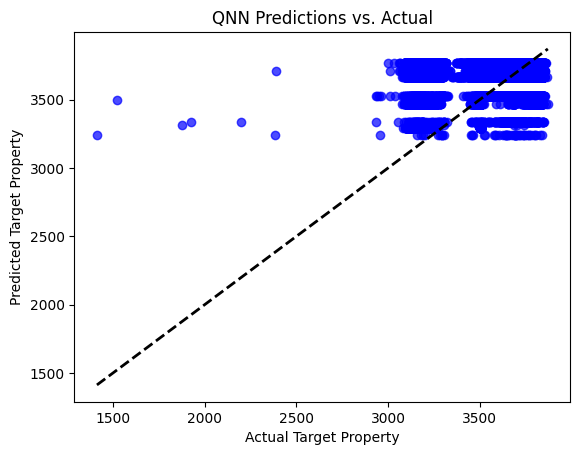

In [43]:
import matplotlib.pyplot as plt

plt.scatter(y_test_original, predictions_original, alpha=0.7, color='blue')
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.xlabel('Actual Target Property')
plt.ylabel('Predicted Target Property')
plt.title('QNN Predictions vs. Actual')
plt.show()
